### O objetivo deste projeto é criar um modelo de Regressāo para fazer previsōes de preços de imóveis

#### 1. Dados

O dataset foi obtido em https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [61]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix
from scipy import stats

%matplotlib inline

In [2]:
#carga de dados

housing_df = pd.read_csv("dados/Housing.csv")
housing_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


#### 2. Análise Exploratória dos dados

In [3]:
#Obtendo informações do dataset

housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing_df.shape

(20640, 10)

In [5]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


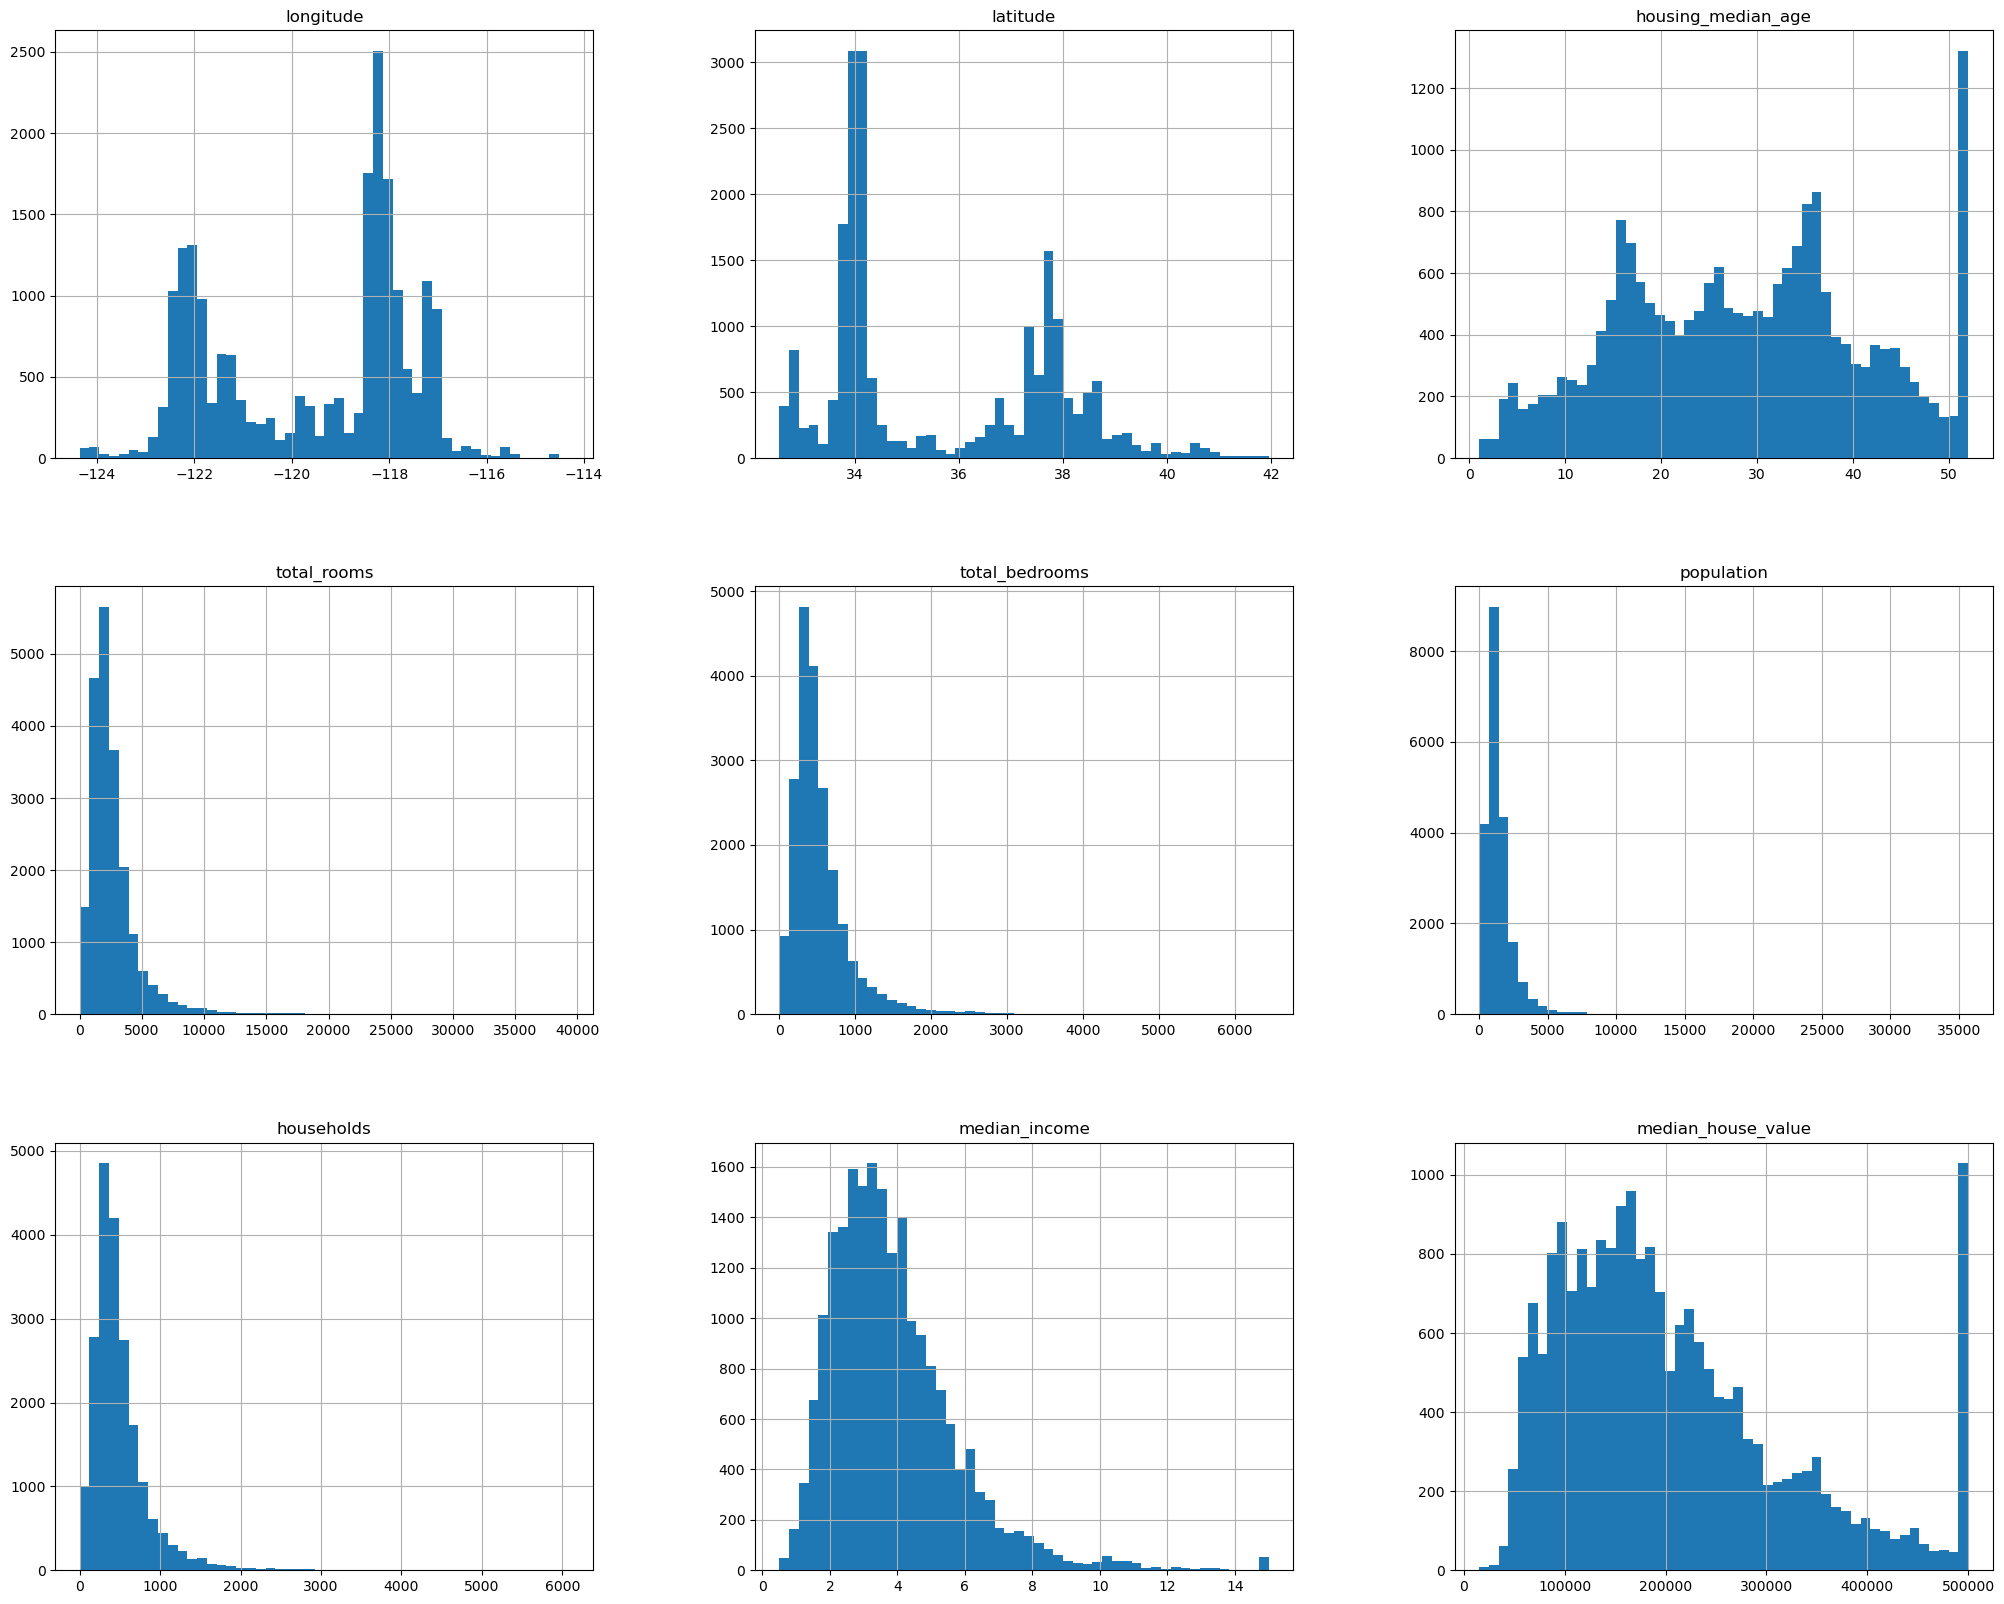

In [6]:
#Distribuiçāo das variáveis

housing_df.hist(bins=50, figsize=(25,20))
plt.show()

<Axes: >

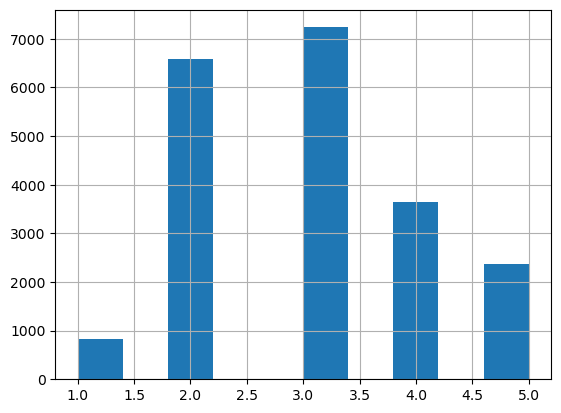

In [7]:
# Dividindo a variável "median_income" em 5 categorias

housing_df["income_cat"] = pd.cut(housing_df["median_income"], 
                                  bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                  labels=[1,2,3,4,5])

housing_df["income_cat"].hist()

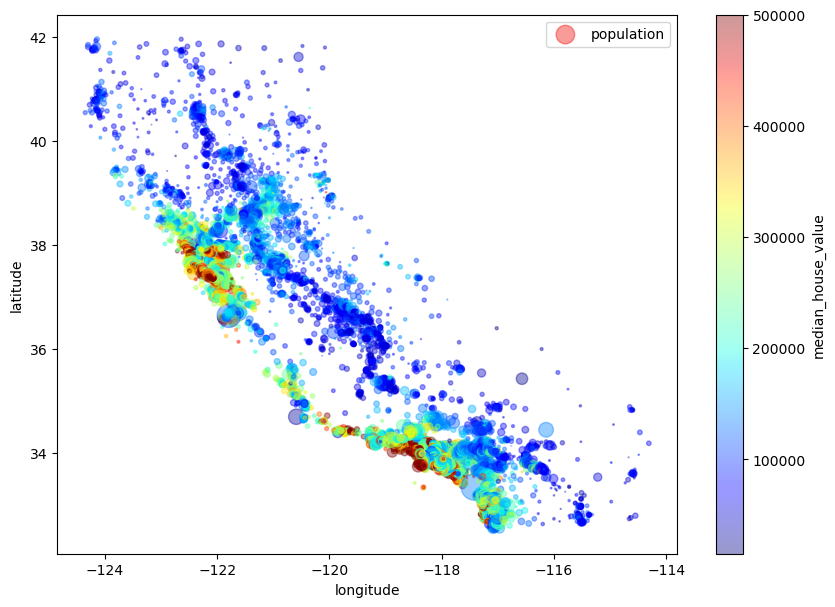

In [8]:
# Gráfico de dispersāo com os dados de latitute e longitude

housing_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
                s=housing_df["population"]/100, label="population", figsize=(10,7),
                c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

Obs. Os raios dos círculos representam a populaçāo e a cor o preço

In [9]:
# Verificando Correlações:

corr_matrix = housing_df.corr()
print(corr_matrix)

                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_

/var/folders/pf/ntcts1kn00zd834rwf3nkb680000gn/T/ipykernel_23673/2507390990.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_df.corr()


In [10]:
# Agora detalhando como é a correlaçāo entre cada variável com a média de valor das casas

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Ao analisarmos as correlações entre as variáveis, pudemos identificar uma correlação negativa leve entre a latitude e o preço médio das casas. Isso indica que há uma tendência de preços mais baixos à medida que nos deslocamos em direção ao norte. Além disso, observamos uma correlação positiva forte entre a renda mediana e o preço médio das casas. Isso significa que áreas com uma mediana de renda mais alta tendem a ter também preços mais altos de imóveis.

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

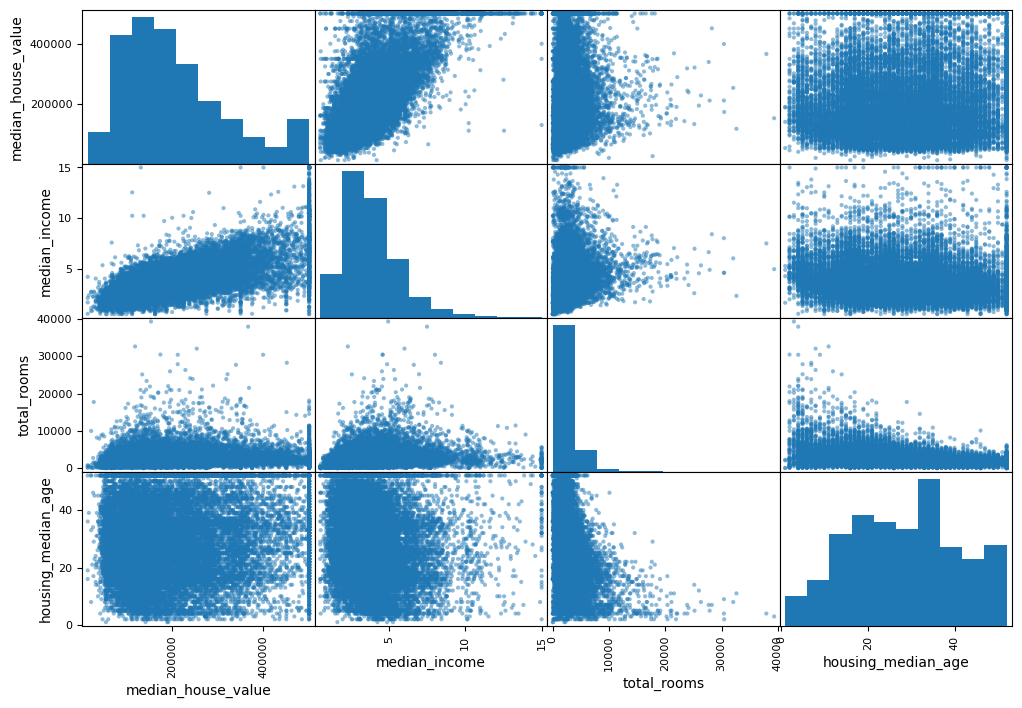

In [11]:
atributos = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_df[atributos], figsize=(12,8))

Na diagonal principal temos os histogramas de distribuiçāo de cada atributo, os demas gráficos plotam a dispersāo entre atributos

<Axes: xlabel='median_income', ylabel='median_house_value'>

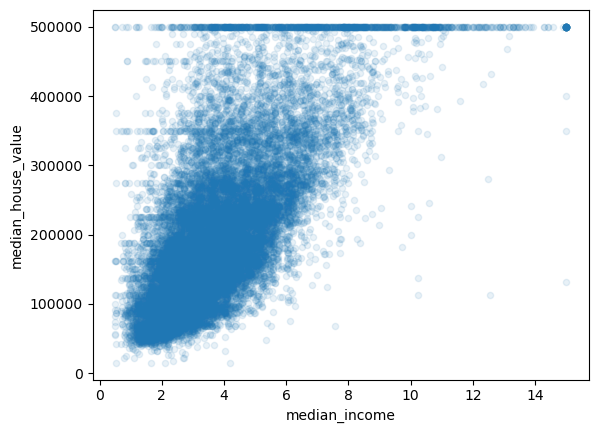

In [12]:
# Analisando o atributo com maior correlaçāo

housing_df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

O gráfico mostra uma correlaçāo de fato forte e que há uma linha no valor de 500.000, indicando um limite de preço.

In [13]:
# Criando algumas colunas

housing_df["rooms_per_household"] = housing_df["total_rooms"]/housing_df["households"]
housing_df["bedrooms_per_room"] = housing_df["total_bedrooms"]/housing_df["total_rooms"]
housing_df["population_per_household"] = housing_df["population"]/housing_df["households"]

housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,6.281853,0.172096,2.181467


In [14]:
# Verificando novamente correlações
corr_matrix = housing_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/var/folders/pf/ntcts1kn00zd834rwf3nkb680000gn/T/ipykernel_23673/2065731646.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_df.corr()


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [15]:
# Tratando dados categóricos

housing_df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [16]:
housing_cat = housing_df[['ocean_proximity']]
housing_cat

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
...,...
20635,INLAND
20636,INLAND
20637,INLAND
20638,INLAND


In [17]:
# Convertendo textos em números

ordinal_encoder = OrdinalEncoder()
housing_cat_encode = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encode

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

In [18]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [19]:
# Usando OneHotEncoding 

cat_enconder = OneHotEncoder()
housing_cat_One_hot = cat_enconder.fit_transform(housing_cat)
housing_cat_One_hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
cat_enconder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### 3. Separar dados para treino e teste

In [21]:
#Separando 20% dos dados para teste de forma aleatória, sem se preocupar com distribuiçāo de classes

train_set, test_set = train_test_split(housing_df, test_size=0.20, random_state=12)

print("Tamanho do conjunto de treino: ",len(train_set))
print("Tamanho do conjunto de teste: ", len(test_set))

Tamanho do conjunto de treino:  16512
Tamanho do conjunto de teste:  4128


In [22]:
#Separando 20% dos dados para teste fazendo amostragem estratificada 
#baseado no campo income_cat gerado a partir de median_income

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)
for train_index, test_index in split.split(housing_df, housing_df["income_cat"]):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

In [23]:
#Verificando proporções:
print("No dataset: ")
print(housing_df["income_cat"].value_counts()/len(housing_df))

print("\nNo conjunto de teste usando amostragem estratificada:")
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))

print("\n No conjunto de teste usando amostragem aleatória:")
print(test_set["income_cat"].value_counts()/len(test_set))


No dataset: 
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

No conjunto de teste usando amostragem estratificada:
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

 No conjunto de teste usando amostragem aleatória:
3    0.337452
2    0.319041
4    0.176841
5    0.125000
1    0.041667
Name: income_cat, dtype: float64


In [24]:
#removendo a coluna income_cat

for i in (strat_train_set, strat_test_set):
    i.drop("income_cat", axis=1, inplace=True)

In [25]:
X_train = strat_train_set.drop("median_house_value", axis = 1)
y_train = strat_train_set["median_house_value"].copy()

In [26]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
18553,-122.04,36.96,42.0,538.0,107.0,200.0,104.0,2.1667,NEAR OCEAN,5.173077,0.198885,1.923077
1522,-122.07,37.91,33.0,1550.0,277.0,638.0,254.0,3.6833,NEAR BAY,6.102362,0.178710,2.511811
9490,-123.21,39.20,17.0,3145.0,693.0,1560.0,647.0,2.2926,<1H OCEAN,4.860896,0.220350,2.411128
16813,-122.42,37.65,39.0,4402.0,894.0,2941.0,887.0,3.8565,NEAR OCEAN,4.962796,0.203090,3.315671
3329,-122.74,38.83,12.0,4515.0,909.0,1554.0,528.0,3.3531,<1H OCEAN,8.551136,0.201329,2.943182


In [27]:
y_train.head()

18553    196400.0
1522     292500.0
9490     149300.0
16813    239800.0
3329      90800.0
Name: median_house_value, dtype: float64

In [28]:
# Tratando dados ausentes no conjunto de treinamento

# Substituindo valores ausentes de "total_bedrooms" pela mediana

median_bedrooms = X_train["total_bedrooms"].median()
X_train["total_bedrooms"].fillna(median_bedrooms, inplace=True)

#### 4. Tranformando dados para treinamento do modelo


In [29]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
# customizando transformações

# selecionando índices das colunas
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [31]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num = housing.drop("ocean_proximity", axis=1) #excluindo coluna sem dados numéricos
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

#### 5. Selecionando e treinando modelo

In [33]:
regressao_linear = LinearRegression()
regressao_linear.fit(housing_prepared, housing_labels)


LinearRegression()

In [34]:
#Fazendo algumas previsões

X, y = housing[:10], housing_labels[:10]
X_prep = full_pipeline.transform(X)
print("Previsões: ", regressao_linear.predict(X_prep))
print("Valores reais:", list(y))

Previsões:  [189312. 211648. 160064. 240768. 193728. 337536. 169408. 209728. 234240.
 334144.]
Valores reais: [196400.0, 292500.0, 149300.0, 239800.0, 90800.0, 500001.0, 168600.0, 208600.0, 178200.0, 369100.0]


#### 6. Avaliando o modelo

In [35]:
previsoes = regressao_linear.predict(housing_prepared)
mse = mean_squared_error(housing_labels, previsoes)
rmse = np.sqrt(mse)

print("MSE=", mse)
print("RMSE=", rmse)

MSE= 4574889550.862524
RMSE= 67637.92982389781


#### 7. Testando outros modelos

In [36]:
arvore_regressao = DecisionTreeRegressor()
arvore_regressao.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [37]:
#Avaliando modelo de árvore de decisāo

previsoes = arvore_regressao.predict(housing_prepared)
mse = mean_squared_error(housing_labels, previsoes)

rmse = np.sqrt(mse)

print("MSE=", mse)
print("RMSE=", rmse)

MSE= 0.0
RMSE= 0.0


Obviamente ocorreu overfitting, nenhum modelo é perfeito

In [38]:
# Testanto outro modelo: 

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)


RandomForestRegressor()

#### 8. Usando Validaçāo Cruzada para avaliar modelos

In [39]:
scores_arvore_reg = cross_val_score(arvore_regressao, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores_arvore_reg = np.sqrt(-scores_arvore_reg)

In [40]:
#Definindo funçāo para mostrar scores

def display_scores(scores):
    print("Scores:", scores)
    print("Média:", scores.mean())
    print("Desvio Padrāo:", scores.std())


In [41]:
display_scores(rmse_scores_arvore_reg)

Scores: [72895.69078188 67409.96134775 67292.51588882 69948.49014593
 69089.573924   73356.60731489 71602.40071681 68634.53364216
 67339.38529049 73583.18217183]
Média: 70115.2341224551
Desvio Padrāo: 2423.6253757292216


In [42]:
scores_reg_lin = cross_val_score(regressao_linear, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores_reg_lin = np.sqrt(-scores_reg_lin)

In [43]:
display_scores(rmse_scores_reg_lin)

Scores: [68219.72281976 66731.91622777 68252.29313865 71713.92824665
 67937.47706625 66347.97294387 66967.39985523 69510.03368479
 67277.85045034 66645.77372422]
Média: 67960.43681575349
Desvio Padrāo: 1547.015612146078


In [44]:
scores_forest_reg = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores_forest_reg = np.sqrt(-scores_forest_reg)

In [45]:
display_scores(rmse_scores_forest_reg)

Scores: [49579.89325581 47402.61566368 49597.43506292 52992.73408332
 51311.53278039 51782.5045316  50780.18705051 50182.6017767
 48809.94504735 49929.50400107]
Média: 50236.89532533576
Desvio Padrāo: 1498.0284808856363


#### 9. Fine-Tune (Ajustando o Modelo)

In [46]:
# Grid Search
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

In [47]:
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [48]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [49]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65589.44875205828 {'max_features': 2, 'n_estimators': 3}
56479.88789373395 {'max_features': 2, 'n_estimators': 10}
53843.6704910648 {'max_features': 2, 'n_estimators': 30}
60824.64405600274 {'max_features': 4, 'n_estimators': 3}
53568.66430267016 {'max_features': 4, 'n_estimators': 10}
51548.680519929985 {'max_features': 4, 'n_estimators': 30}
60243.85107819729 {'max_features': 6, 'n_estimators': 3}
53302.07876507234 {'max_features': 6, 'n_estimators': 10}
50976.624914911656 {'max_features': 6, 'n_estimators': 30}
59390.83100166831 {'max_features': 8, 'n_estimators': 3}
53143.91034282232 {'max_features': 8, 'n_estimators': 10}
50782.35045760725 {'max_features': 8, 'n_estimators': 30}
63954.16954556231 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55494.454779655665 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61654.63768638607 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53779.07495423603 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [51]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.87718962e-02, 6.02649952e-02, 3.86443607e-02, 1.30952587e-02,
       1.27494887e-02, 1.35861485e-02, 1.24415963e-02, 3.15640448e-01,
       2.65052077e-02, 6.06659173e-02, 5.40211230e-02, 4.10380555e-02,
       7.61730270e-02, 4.84803836e-02, 8.15751240e-03, 1.52752033e-01,
       7.71928293e-05, 3.02303325e-03, 3.91232282e-03])

In [56]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.31564044776355976, 'median_income'),
 (0.15275203258262762, 'INLAND'),
 (0.07617302696860506, 'pop_per_hhold'),
 (0.06066591729122747, 'bedrooms_per_room'),
 (0.06026499517618312, 'latitude'),
 (0.058771896157651465, 'longitude'),
 (0.054021122973384274, 'population_per_household'),
 (0.048480383643302344, 'bedrooms_per_room'),
 (0.04103805554300419, 'rooms_per_hhold'),
 (0.03864436065685483, 'housing_median_age'),
 (0.026505207677529886, 'rooms_per_household'),
 (0.013586148526781389, 'population'),
 (0.013095258685234524, 'total_rooms'),
 (0.012749488730040785, 'total_bedrooms'),
 (0.012441596326869413, 'households'),
 (0.008157512403443737, '<1H OCEAN'),
 (0.003912322818955767, 'NEAR OCEAN'),
 (0.003023033245447564, 'NEAR BAY'),
 (7.719282929662705e-05, 'ISLAND')]

In [57]:
final_model = grid_search.best_estimator_

In [58]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [59]:
final_predictions = final_model.predict(X_test_prepared)

In [60]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [62]:
confianca = 0.95
erros_quadraticos = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confianca, len(erros_quadraticos) -1, loc=erros_quadraticos.mean(), scale = stats.sem(erros_quadraticos)))

array([48377.4056286 , 52652.66684067])